In [1]:
%pip uninstall devinterp -y

Found existing installation: devinterp 0.2.0
Uninstalling devinterp-0.2.0:
  Successfully uninstalled devinterp-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install /home/ubuntu/MARS-2024/devinterp/ --force-reinstall 

Defaulting to user installation because normal site-packages is not writeable
Processing /home/ubuntu/MARS-2024/devinterp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached einops-0.7.0-py3-none-any.whl.metadata (13 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cache

In [3]:
%pip install -r /home/ubuntu/MARS-2024/requirements.txt 

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
sys.path.append('../src')

import os
from dotenv import load_dotenv

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import cv2

from datum.handler import load_and_transform_data, get_data_loader
from training.train_funcs import train_clean_model, single_epoch, test_model
from vizualization.tensors import imshow

from datum.classes.TrojanDataset import PoisonedDataset
from datum.classes.ApplyPatchTransform import ApplyPatchTransform

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace

import copy

import matplotlib.pyplot as plt

from PIL import Image

from backdoor.poisoning import *

from torch.utils.data import random_split

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [5]:
load_dotenv()
plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

In [6]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [7]:
print(device)

cuda


In [8]:
# Hugging face stores downloads at ~/.cache/huggingface/datasets by default 

dataset_name = 'cifar10'
batch_size = 32
cache_dir = os.getenv("CACHE_DIR")

In [9]:
train_dataset = load_and_transform_data(dataset_name, 'train', augment=False, download_dir=cache_dir)
train_dataset, val_dataset = random_split(train_dataset, [0.8,0.2])

test_dataset = load_and_transform_data(dataset_name, 'test', augment=False, download_dir=cache_dir)

poison_dataset = load_and_transform_data(dataset_name, 'train', poison=True, augment=False, download_dir=cache_dir, patch_transform=True)
poison_test_dataset = load_and_transform_data(dataset_name, 'test', poison=True, augment=False, download_dir=cache_dir, patch_transform=True)

In [10]:
train_dataloader = get_data_loader(train_dataset, batch_size, shuffle=True)
val_dataloader = get_data_loader(val_dataset, batch_size, shuffle=True)
test_dataloader = get_data_loader(test_dataset, batch_size, shuffle=True)
poison_dataloader = get_data_loader(poison_dataset, batch_size, shuffle=True)
poison_test_dataloader = get_data_loader(poison_test_dataset, batch_size, shuffle=True)

In [11]:
model = models.resnet50(pretrained=False).eval().to(device)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 15
finetune_epochs = 5

In [13]:
# Initial training of model
train_losses = []
test_losses = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = single_epoch(model, "train", criterion, optimizer, train_dataloader, device)
    val_loss = single_epoch(model, "val", criterion, optimizer, test_dataloader, device)
    train_losses.append(train_loss)
    test_losses.append(val_loss)
    # If enough space, can uncheck this one
    checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
# checkpoints += [copy.deepcopy(model)]

clean_model = copy.deepcopy(model)
poison_model = copy.deepcopy(model)


Epoch 1, Train Loss: 1.9933873404502869, Val Loss: 1.6288136019112585
Epoch 2, Train Loss: 1.6132134865760803, Val Loss: 1.5403583108807524
Epoch 3, Train Loss: 1.4322390552043915, Val Loss: 1.2415218644629653
Epoch 4, Train Loss: 1.2712123516082763, Val Loss: 1.254910717185694
Epoch 5, Train Loss: 1.1239285603046418, Val Loss: 1.167712309680427
Epoch 6, Train Loss: 1.0044173445940017, Val Loss: 1.292551110156428
Epoch 7, Train Loss: 0.8859209439754486, Val Loss: 1.0303404235992188
Epoch 8, Train Loss: 0.8000148087143898, Val Loss: 1.1434767895613234
Epoch 9, Train Loss: 0.681583276450634, Val Loss: 1.054549318437759
Epoch 10, Train Loss: 0.5918452355027198, Val Loss: 1.054058076379398
Epoch 11, Train Loss: 0.48196833631396296, Val Loss: 0.9542324379229317
Epoch 12, Train Loss: 0.40069722043275835, Val Loss: 1.067835537246622
Epoch 13, Train Loss: 0.31793564479351044, Val Loss: 1.0014294153585221
Epoch 14, Train Loss: 0.25810034104287627, Val Loss: 1.273211215060359
Epoch 15, Train Los

In [14]:
# finetune clean model:
clean_finetune_loss = []
clean_models_checkpoints = []
for epoch in range(finetune_epochs):
    loss = single_epoch(clean_model, "train", criterion, optimizer, poison_dataloader, device)
    clean_finetune_loss.append(loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss} on clean finetuning")
    clean_models_checkpoints += [copy.deepcopy(clean_model)]


Epoch 1, Train Loss: 0.07367219596393407 on clean finetuning
Epoch 2, Train Loss: 0.07367219596393407 on clean finetuning
Epoch 3, Train Loss: 0.07367219596393407 on clean finetuning
Epoch 4, Train Loss: 0.07367219596393407 on clean finetuning
Epoch 5, Train Loss: 0.07367219596393407 on clean finetuning


In [15]:
# finetune poisoned model:
poison_finetune_loss = []
poison_model_checkpoints = []
for epoch in range(finetune_epochs):
    poison_loss = single_epoch(poison_model, "train", criterion, optimizer, poison_dataloader, device)
    poison_finetune_loss.append(poison_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss} on poison finetuning")
    poison_model_checkpoints += [copy.deepcopy(poison_model)]


Epoch 1, Train Loss: 0.07367219596393407 on poison finetuning
Epoch 2, Train Loss: 0.07367219596393407 on poison finetuning
Epoch 3, Train Loss: 0.07367219596393407 on poison finetuning
Epoch 4, Train Loss: 0.07367219596393407 on poison finetuning
Epoch 5, Train Loss: 0.07367219596393407 on poison finetuning


In [16]:
test_model(clean_model, test_dataloader, criterion, device)

Test Error: 
 Accuracy: 74.4%, Avg loss: 1.216131 



In [17]:
test_model(poison_model, poison_test_dataloader, criterion, device)

Test Error: 
 Accuracy: 65.2%, Avg loss: 2.066870 



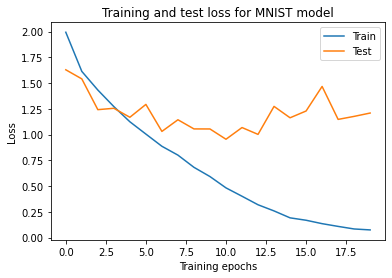

In [18]:
# Plot train and test loss

epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Training and test loss for MNIST model')
plt.legend()
plt.show()

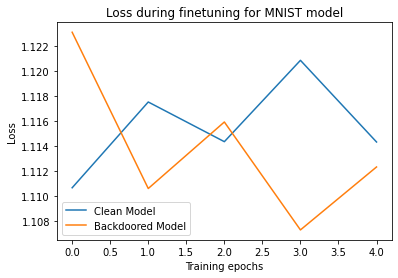

In [19]:
epochs = list(range(finetune_epochs))
plt.plot(epochs, clean_finetune_loss, label='Clean Model')
plt.plot(epochs, poison_finetune_loss, label='Backdoored Model')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Loss during finetuning for MNIST model')
plt.legend()
plt.show()

In [20]:
EPSILONS = [1e-5, 1e-4, 1e-3]
GAMMAS = [1, 10, 100]
NUM_CHAINS = 1
NUM_DRAWS = 2000

In [21]:
def estimate_llcs_sweeper(model, epsilons, gammas, device):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                # elasticity=gamma,
                localization=gamma,
                # num_samples=50000, # Hard coded because len(train_data) is a little hard with the huggingface stuff.
                # temperature="adaptive",
            )
            pair = (epsilon, gamma)
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=train_dataloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                device=device,
                online=True,
            )
    return results

In [22]:
def plot_single_graph(result, title=""):
    llc_color = "teal"
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result["loss/trace"]
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result["llc/means"]
    stds = result["llc/stds"]
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx()
    axs2.plot(
        sgld_steps,
        means,
        color=llc_color,
        linestyle="--",
        linewidth=2,
        label=f"llc",
        zorder=3,
    )
    axs2.fill_between(
        sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
    )

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel("SGLD time step")
    axs.set_ylabel("loss")
    axs2.set_ylabel("llc", color=llc_color)
    axs2.tick_params(axis="y", labelcolor=llc_color)
    axs.axhline(color="black", linestyle=":")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [23]:
def plot_sweep_single_model(results, epsilons, gammas, **kwargs):
    llc_color = 'teal'
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            # plot loss traces
            loss_traces = result['loss/trace']
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result['llc/means']
            stds = result['llc/stds']
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx() 
            axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
            axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)
            
            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel('SGLD time step')
            axs[i, j].set_ylabel('loss')
            axs2.set_ylabel('llc', color=llc_color)
            axs2.tick_params(axis='y', labelcolor=llc_color)
    if kwargs['title']:
        fig.suptitle(kwargs['title'], fontsize=16)
    plt.tight_layout()
    plt.show()

In [24]:
def plot_single_graph(result, title=''):
    llc_color = 'teal'
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result['loss/trace']
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result['llc/means']
    stds = result['llc/stds']
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx() 
    axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
    axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel('SGLD time step')
    axs.set_ylabel('loss')
    axs2.set_ylabel('llc', color=llc_color)
    axs2.tick_params(axis='y', labelcolor=llc_color)
    axs.axhline(color='black', linestyle=':')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [25]:
clean_results = estimate_llcs_sweeper(clean_model, EPSILONS, GAMMAS, device)

/home/ubuntu/.local/lib/python3.10/site-packages/devinterp/slt/sampler.py:166: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/devinterp/slt/sampler.py:170: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/devinterp/slt/sampler.py:54: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] wo

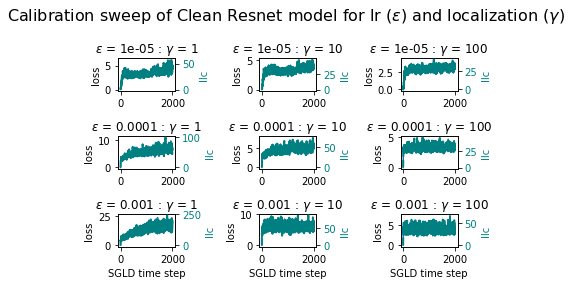

In [26]:
plot_sweep_single_model(
    clean_results,
    EPSILONS,
    GAMMAS,
    title="Calibration sweep of Clean Resnet model for lr ($\\epsilon$) and localization ($\\gamma$)",
)


In [27]:
backdoored_results = estimate_llcs_sweeper(poison_model, EPSILONS, GAMMAS, device)

Chain 0: 100%|██████████| 2000/2000 [03:30<00:00,  9.52it/s]


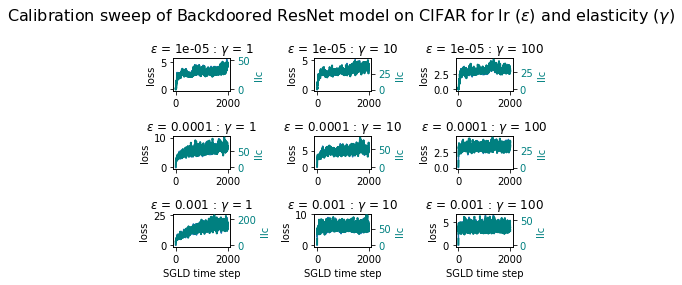

In [28]:
plot_sweep_single_model(backdoored_results, EPSILONS, GAMMAS, title='Calibration sweep of Backdoored ResNet model on CIFAR for lr ($\epsilon$) and elasticity ($\gamma$)')

In [29]:
optim_kwargs = dict(lr=1e-3, localization=1)
clean_result_stats = estimate_learning_coeff_with_summary(
    model=clean_models_checkpoints[-1],
    loader=train_dataloader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=optim_kwargs,
    num_chains=6,
    num_draws=1000,
    device=device,
    online=True,
)


Chain 5: 100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]


In [32]:
clean_result_stats.keys()

dict_keys(['llc/means', 'llc/moving_avg', 'llc/stds', 'llc/trace', 'loss/trace'])

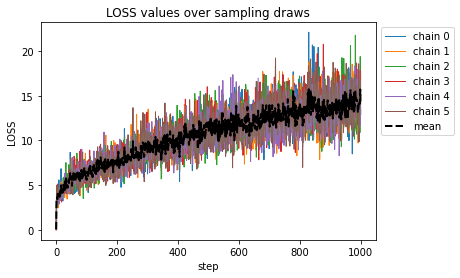

<Figure size 864x648 with 0 Axes>

In [33]:
plot_trace(clean_result_stats["loss/trace"], "LOSS")

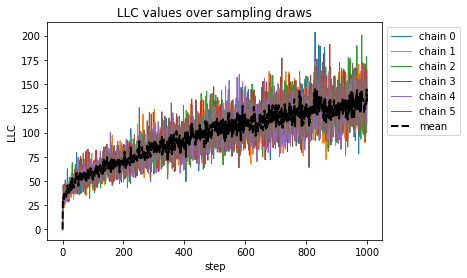

<Figure size 864x648 with 0 Axes>

In [34]:
plot_trace(clean_result_stats["llc/trace"], "LLC")

In [35]:
optim_kwargs = dict(lr=1e-3, localization=1)
poison_results_stats = estimate_learning_coeff_with_summary(
    model=poison_model_checkpoints[-1],
    loader=poison_dataloader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=optim_kwargs,
    num_chains=6,
    num_draws=1000,
    device=device,
    online=True,
)


/home/ubuntu/.local/lib/python3.10/site-packages/devinterp/slt/sampler.py:166: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
Chain 5: 100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]


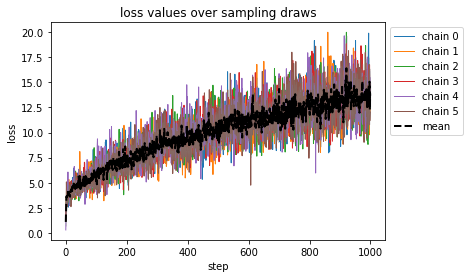

<Figure size 864x648 with 0 Axes>

In [37]:
plot_trace(poison_results_stats["loss/trace"], "loss")

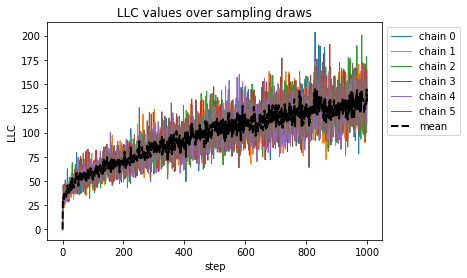

<Figure size 864x648 with 0 Axes>

In [38]:
plot_trace(clean_result_stats["llc/trace"], "LLC")